In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# set seed
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# define the non-linear target function
def true_function(X):
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + \
           0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# function to generate input and noisy output samples
def generate_data(n_samples=1000):
    X = tf.random.uniform((n_samples, 3), -2, 2)
    y_true = true_function(X)
    y_noisy = y_true + tf.random.normal((n_samples,), stddev=0.5)
    return X, tf.reshape(y_noisy, (-1, 1))

# creating training and test sets
X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(200)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (1000, 3)
Test data shape: (200, 3)


In [3]:
# create a simple 3-layer dense network
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, kernel_initializer='he_normal')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
# compile the model with optimizer and loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mse',
    metrics=['mae']
)

# defining training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-4)
]

In [5]:
start = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=3000,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Epoch 1/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 12.1159 - mae: 2.9353 - val_loss: 9.2243 - val_mae: 2.5084 - learning_rate: 0.0050
Epoch 2/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2723 - mae: 2.3614 - val_loss: 6.9122 - val_mae: 2.1657 - learning_rate: 0.0050
Epoch 3/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1645 - mae: 2.0262 - val_loss: 5.1810 - val_mae: 1.9039 - learning_rate: 0.0050
Epoch 4/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5462 - mae: 1.7489 - val_loss: 3.8600 - val_mae: 1.6473 - learning_rate: 0.0050
Epoch 5/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3815 - mae: 1.5089 - val_loss: 3.0593 - val_mae: 1.4638 - learning_rate: 0.0050
Epoch 6/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7231 - mae: 1.3574 - val_loss: 2.6345 - val_mae: 1.3650 - learning_rate: 0.0050
Epoch 7/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3685 - mae: 1.2693 - val_loss: 2.3989 - val_mae: 1.3048 - learning_rate: 0.0050
E

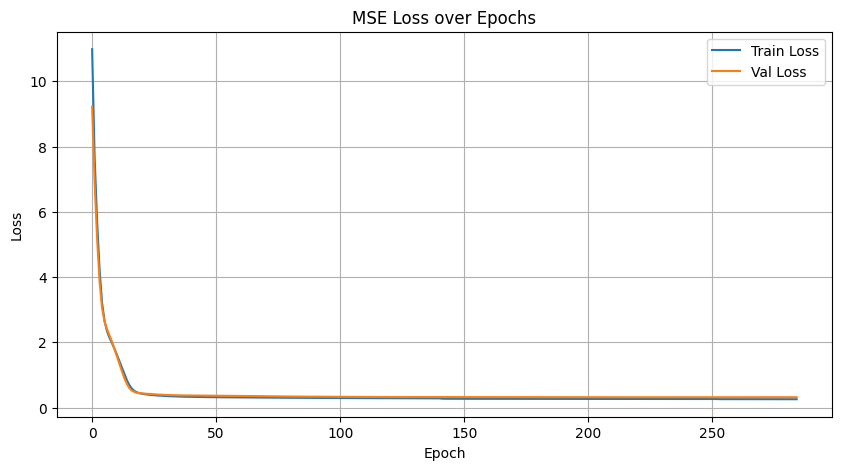

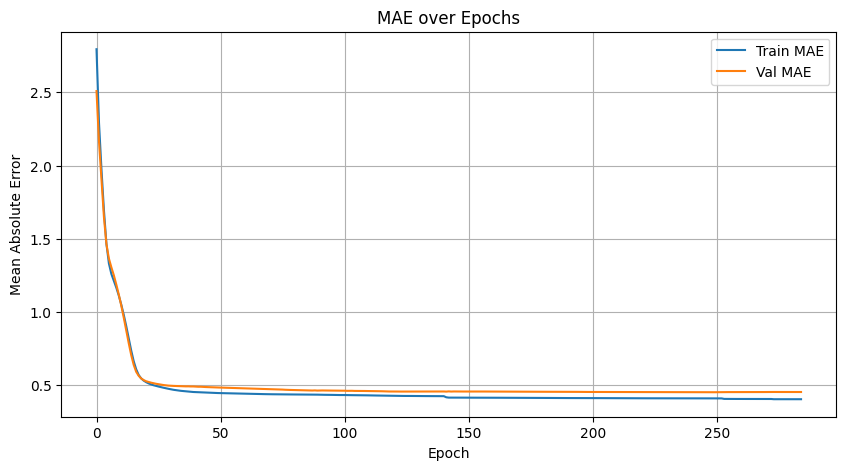

In [6]:
# plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("MSE Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# plot training vs validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# evaluate performance on test data
results = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2910 - mae: 0.4313 
Test Loss (MSE): 0.3169
Test MAE: 0.4525


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


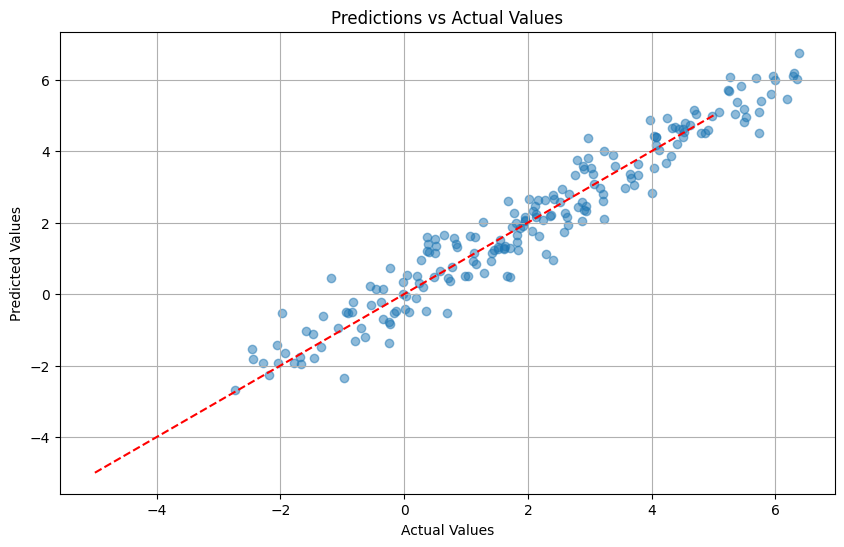

In [8]:
# predict on test data
y_pred_test = model.predict(X_test)

# plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_test, alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.grid(True)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


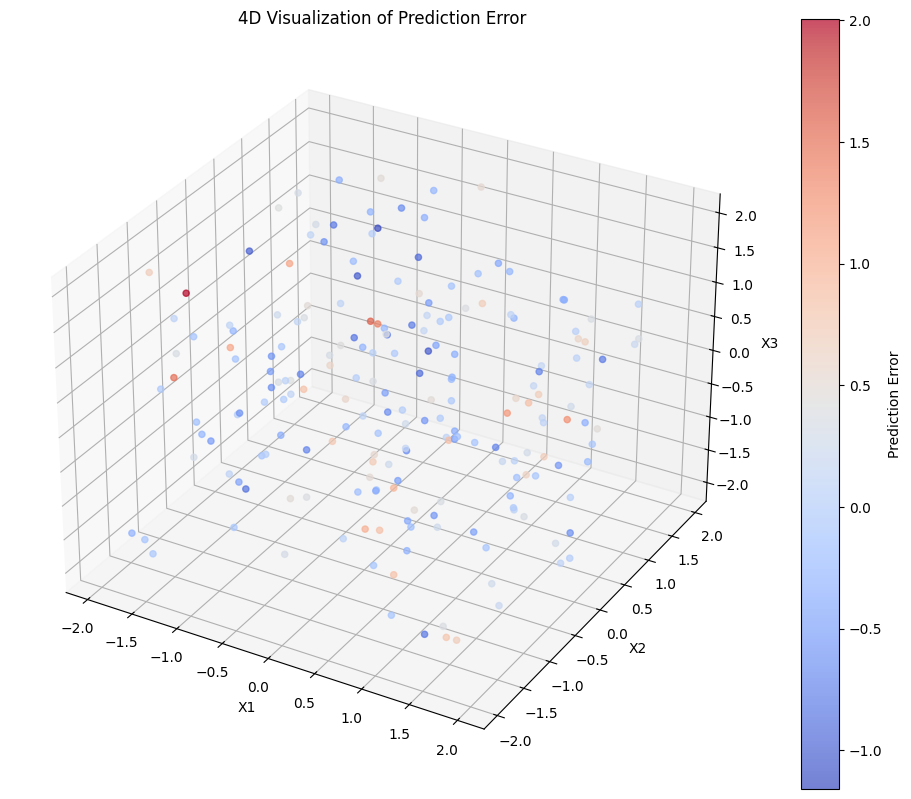

In [9]:
# 3D plot with prediction error
def visualize_4d(X, y_true, y_pred, title):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    error = y_true.numpy().flatten() - y_pred.flatten()
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=error, cmap=cm.coolwarm, alpha=0.7)
    plt.colorbar(scatter, label='Prediction Error')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)
    plt.show()

X_vis, y_vis = generate_data(200)
y_vis_pred = model.predict(X_vis)
visualize_4d(X_vis, y_vis, y_vis_pred, "4D Visualization of Prediction Error")

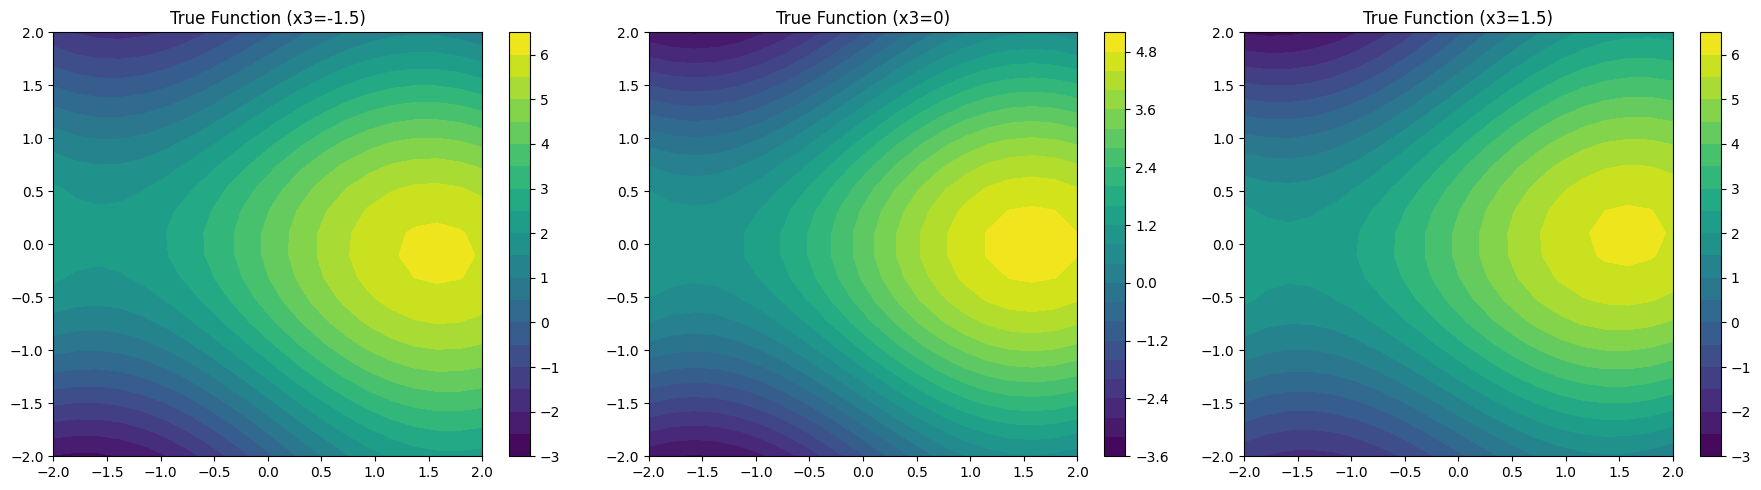

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


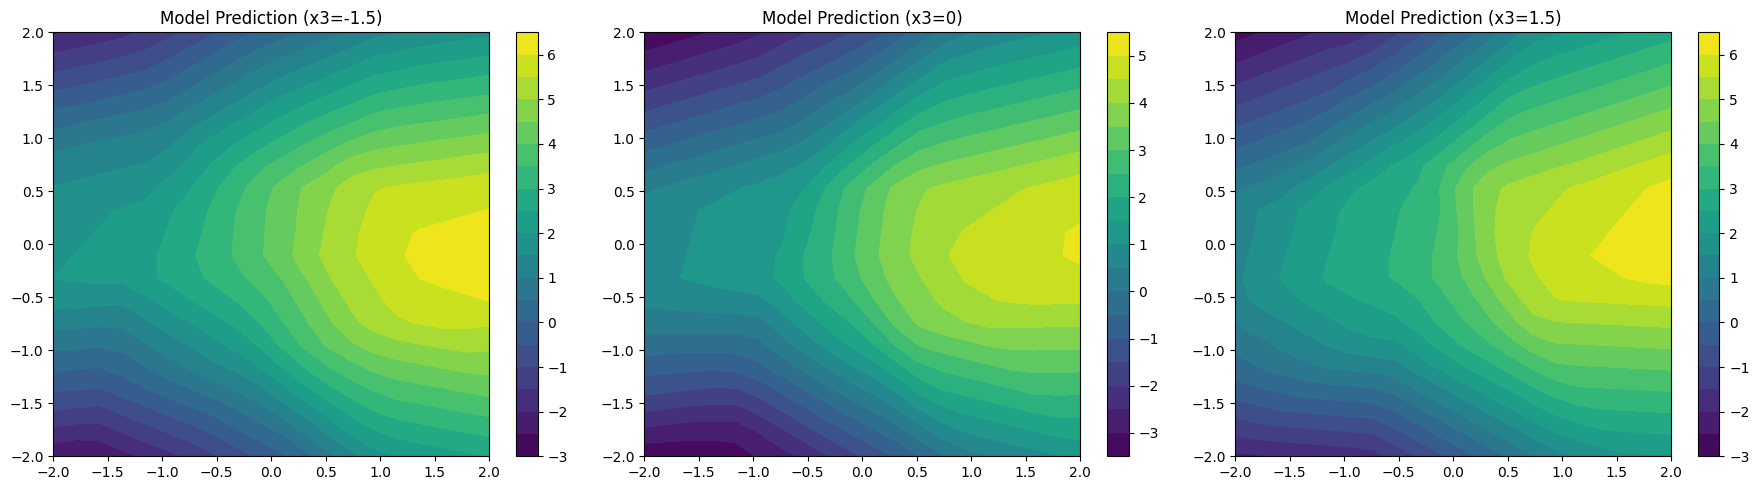

In [10]:
# plot 2D slices of the function and model prediction at fixed X3 values
def plot_2d_slices(X_range=2.0, grid_points=20):
    x1 = np.linspace(-X_range, X_range, grid_points)
    x2 = np.linspace(-X_range, X_range, grid_points)
    x3_values = [-1.5, 0, 1.5]

    # true function plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, x3 in enumerate(x3_values):
        X1, X2 = np.meshgrid(x1, x2)
        X_input_np = np.zeros((grid_points**2, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        im = axes[i].contourf(X1, X2, y_true, levels=20, cmap='viridis')
        axes[i].set_title(f"True Function (x3={x3})")
        plt.colorbar(im, ax=axes[i])
    plt.tight_layout()
    plt.show()

    # predicted function plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, x3 in enumerate(x3_values):
        X1, X2 = np.meshgrid(x1, x2)
        X_input_np = np.zeros((grid_points**2, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)
        y_pred = model.predict(X_input).reshape(grid_points, grid_points)
        im = axes[i].contourf(X1, X2, y_pred, levels=20, cmap='viridis')
        axes[i].set_title(f"Model Prediction (x3={x3})")
        plt.colorbar(im, ax=axes[i])
    plt.tight_layout()
    plt.show()

plot_2d_slices()